# __ACA dark current map__

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import pyyaks.logger
import numpy.ma as ma
import collections

In [2]:
#   For each image, pick out the 'X's
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  XXXXXXXX  |        X....X
#   |/ XX....XX  |/       X....X
#      XX....XX           X....X
#      XX....XX           X....X
#      XX....XX           .XXXX.
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

#r = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
#     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
#     2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]
#c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7]
#

# OR
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->

r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]

r_all = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
     3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7]
c_all = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]


### Functions ###

In [4]:
def get_frame_row(frame_data, img_size): # frame_data = current row in Table(slot_data)
    
    # frame_row is a dict that combines current slot_data such as
    # IMGROW0, IMGCOL0, IMGRAW, BGDAVG, and a dict of edge pixel vals
    frame_row = collections.OrderedDict()
    
    row0 = frame_data['IMGROW0'][0]
    col0 = frame_data['IMGCOL0'][0]
    raw_image = frame_data['IMGRAW'][0]
    
    # Pick out the edge pixels
    frame_row['edge_vals'] = edge_pixels_dict_8x8(raw_image, row0, col0)
        
    frame_row['row0'] = row0
    frame_row['col0'] = col0
    frame_row['raw_img'] = raw_image
    frame_row['bgdavg'] = frame_data['BGDAVG'][0]
    frame_row['time'] = frame_data['TIME'][0]

    return frame_row


def edge_pixels_dict_8x8(raw_image, row0, col0):

    edge_pixels_dict = collections.OrderedDict()
    
    raw_image = raw_image.reshape(8, 8, order='F')
    
    for rr, cc in zip(r, c): # (r, c) define location of edge pixels (X's)
        r_abs = col0 + rr + shift # <-- Add col0 to rr!
        c_abs = row0 + cc + shift
        key = (r_abs, c_abs) # e.g. (781, 428), a tuple
        edge_pixels_dict[key] = raw_image[rr, cc]
        
    return edge_pixels_dict


def update_deque_dict(deque_dict, frame_row):
    # Update deque_dict:
    # 1. Compute current coordinates of the edge pixels (0:1023)
    # 2. extend or init deque with edge value if we are on the edge
    # 3. if > ndeque elements in a deque, pop the first one
    
    # current edge row/col coords in 0:1023
    # Add col0 to 'image row', and row0 to 'image column'!
    r_current_edge = r + (frame_row['col0'] + shift) * np.ones(len(r))
    c_current_edge = c + (frame_row['row0'] + shift) * np.ones(len(c))
    
    for (rr, cc) in zip(r_current_edge, c_current_edge):
        if (rr, cc) in deque_dict.keys():    
            deque_dict[(rr, cc)].extend([frame_row['edge_vals'][(rr, cc)]])                
            deque_dict[(-rr, -cc)].extend([frame_row['time']]) # <-- record time               
            # Keep the length at ndeque
            if len(deque_dict[(rr, cc)]) > ndeque:
                deque_dict[(rr, cc)].pop()
        else: # initialize
            deque_dict[(rr, cc)] = collections.deque([frame_row['edge_vals'][(rr, cc)]])                   
            deque_dict[(-rr, -cc)] = collections.deque([frame_row['time']])                   
            
    return deque_dict


def pixel_background(frame_row, img_size, deque_dict, bgd='mixed'):

    row0 = frame_row['row0']
    col0 = frame_row['col0']
    bgdavg = frame_row['bgdavg']

    bgd_img = np.zeros((img_size, img_size))
    
    for rr in range(8):
        for cc in range(8):
    #for (rr, cc) in zip(r_all, c_all): # would this be faster?
            key = (rr + col0 + shift, cc + row0 + shift) # <-- col0 goes with rr!
            if key in deque_dict.keys():
                bgd_img[rr, cc] = np.median(deque_dict[key])
            else:
                if bgd == 'mixed':
                    bgd_img[rr, cc] = bgdavg

    return bgd_img


# img_size = 6 science observation
# img_size = 8 ER observation
# img_mask = None for science observations
def get_current_centroids(img, img_size):
    
    if img_size not in [6, 8]:
        raise Exception("Image size outside of allowed values [6, 8] (6x6 or 8x8)")
        
    num = np.arange(0.5, 6.5)

    #How relevant is this?
    if (img_size == 8):
        img = zero_6x6_corners(img, centered=True)
    else:
        img = zero_6x6_corners(img, centered=False)
    
    centroids = []
    for ax in [0, 1]:
        # Def of flat is where img_mask becomes relevant for ER data and telemetry comparison
        flat = np.sum(img, axis=ax)
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2])  # 0:6
        else:
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1]) + 1  # 1:7, is +1 relevant?
        centroids.append(centroid)
        
    return centroids


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if len(img) != 8 or len(img.shape) != 2:
        raise Exception("Img should be a 8x8 array")
    if centered:
        r = [1, 1, 6, 6]
        c = [1, 6, 1, 6]
    else:
        r = [0, 0, 5, 5]
        c = [0, 5, 0, 5]
    for rr, cc in zip(r, c):
        img[rr][cc] = 0.0
    return img


# In 8x8 img, mask the edge pixels, leave r/c 1:7 unmasked.
# For science observations the raw image is masked by default (r/c 0:6 are left unmasked).
def get_mask_8x8_centered():
    m = """\
        1 1 1 1 1 1 1 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1"""
    mask = np.array([line.split() for line in m.splitlines()], dtype=float)
    return mask

In [6]:
def get_centroids(slot_data, img_size, bgd='mixed'):
    # Calls:
    #     get_frame_row
    #     update_deque_dict
    #     pixel_background
    #     get_current_centroids
    #
    
    if bgd not in ['bgdavg', 'dark_current', 'mixed']:
        raise Exception("get_centroids:: bgd should be one of bgdavg, dark_current, mixed")
    
    nn = len(slot_data)
    #nn = 17 # for testing decrease the number of processed frames
    
    deque_dict = collections.OrderedDict()
    
    yagzag_centroids = []

    for index in range(0, nn):
        
        frame_data = slot_data[index:index + 1]
        frame_row = get_frame_row(frame_data, img_size)
        
        # Background subtraction for the current 8x8 image
        # 1. Update deque_dict.
        # 2. Compute bgd_img. Depending on 'bgd' argument:
        #        - 'bgdavg': avg background (current algorithm)
        #        - 'dark_current': median for sampled pixels, zero for not sampled pixels
        #        - 'mixed': median for sampled pixels, avg bgd for not sampled pixels
        # 3. Subtract bgd from the raw image

        if bgd in ['dark_current', 'mixed']:
            deque_dict = update_deque_dict(deque_dict, frame_row)
            bgd_img = pixel_background(frame_row, img_size, deque_dict, bgd=bgd)
        else:
            bgd_img = frame_row['bgdavg'] * np.ones((8, 8))
            
        raw_img = frame_row['raw_img']
        raw_img = raw_img.reshape(8, 8, order='F')
                    
        # Subtract background img and mask the edge before computing the
        # first moments using the 6x6 modified (?) pixels
        
        #img = raw_img - bgd_img

        # Don't oversubtract, px with bgd > raw val will be set to zero
        bgd_mask = bgd_img > raw_img
        img = raw_img - ma.array(bgd_img, mask=bgd_mask)
        img = img.data * ~bgd_mask
        
        img = ma.array(img, mask=img_mask)
        
        # Test: uncomment and change nn to 17 to check the bgd img computation
        #print 'Row0, col0: ', frame_row['row0'], frame_row['col0']
        #print 'Raw image: ', raw_img
        #print 'Bgd image: ', bgd_img
        #print 'Image: ', img
        #print deque_dict
                        
        # Calculate centroids for current bgd subtracted img, use first moments
        centroids = get_current_centroids(img, img_size)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = centroids[0] + frame_row['row0'] # do not add shift
        z_pixel = centroids[1] + frame_row['col0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)

        yagzag_centroids.append(yagzag)
                                   
    return yagzag_centroids, deque_dict

In [7]:
def centroids(slots, img_size, bgd='mixed'):
   
    rows = []

    for slot in slots:
        print 'Slot = {}'.format(slot)
        slot_row = {'slot':slot, 'row0':[], 'col0':[], 'yan_raw':[], 'zan_raw':[]}
    
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        
        cntrds, bgd_pixel_series = get_centroids(slot_data, img_size, bgd=bgd)

        slot_data = Table(slot_data)
        time = slot_data['TIME']
        
        slot_row['time'] = time
        slot_row['row0'] = slot_data['IMGROW0']
        slot_row['col0'] = slot_data['IMGCOL0']
        
        raw_yagzag = np.array(cntrds).T # [0] - yag, [1] - zag
    
        slot_row['yan_raw'].append(raw_yagzag[0])
        slot_row['zan_raw'].append(raw_yagzag[1])

        slot_row['bgd_px_series'] = bgd_pixel_series
        
        rows.append(slot_row)
    
    return rows

In [9]:
# Plotting functions

def plot_d_ang(key, dt, t):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t[key][slot][0], t['time'][slot] + dt[i],
                                           t['time'][2],
                                           method="nearest")
        d_ang = t[key][2][0] - ang_interp
        plt.plot(t['time'][2], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return

### Computations ###

In [10]:
# 50804, stars in all slots tracked, star in slot 7 faint, all other stars bright
obsid = 50804
img_mask = get_mask_8x8_centered()
dwell = events.dwells.filter(obsid=obsid)[0]

In [11]:
img_size = 8
slots = range(8)
shift = 512 # so that we end up with coordinates in the 0:1023 range
ndeque = 1000 # number of vals in deque before we start to pop()

In [12]:
# bgd:
#    bgdavg - subtract average background (current algorithm)
#    dark_current - subtract only dark current (median), for pixels not on the list do nothing
#    mixed - subtract dark current (median), for pixels not on the list use current avg bgd

In [13]:
bgd = 'bgdavg'
rows_ba = centroids(slots, img_size, bgd=bgd) # series will be empty

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [14]:
bgd = 'dark_current'
rows_dc = centroids(slots, img_size, bgd=bgd)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [15]:
bgd = 'mixed'
rows_m = centroids(slots, img_size, bgd=bgd)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [16]:
t_ba = Table(rows_ba)

In [17]:
t_dc = Table(rows_dc)

In [18]:
t_m = Table(rows_m)

[(479.0, 888.0), (-479.0, -888.0), (479.0, 889.0), (-479.0, -889.0), (486.0, 882.0), (-486.0, -882.0), (486.0, 883.0), (-486.0, -883.0)]


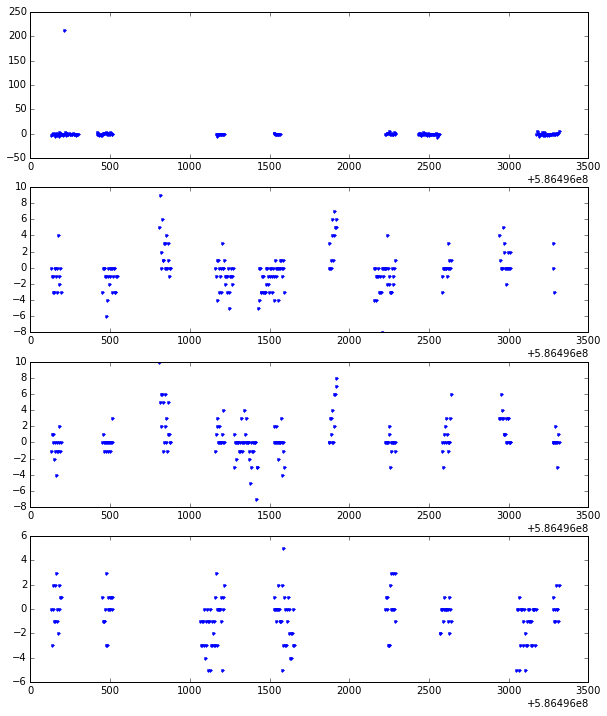

In [20]:
keys =  t_m[0]['bgd_px_series'].keys()[12:20]

print keys

fig = plt.figure(figsize=(10, 12))

for i, key in enumerate(keys):
    if i % 2 == 0:
        plt.subplot(4, 1, i // 2)
        key_time = (-key[0], -key[1])
        plt.plot(t_dc[0]['bgd_px_series'][key_time], t_dc[0]['bgd_px_series'][key], '.')

In [21]:
print t_ba.colnames

['bgd_px_series', 'col0', 'row0', 'slot', 'time', 'yan_raw', 'zan_raw']


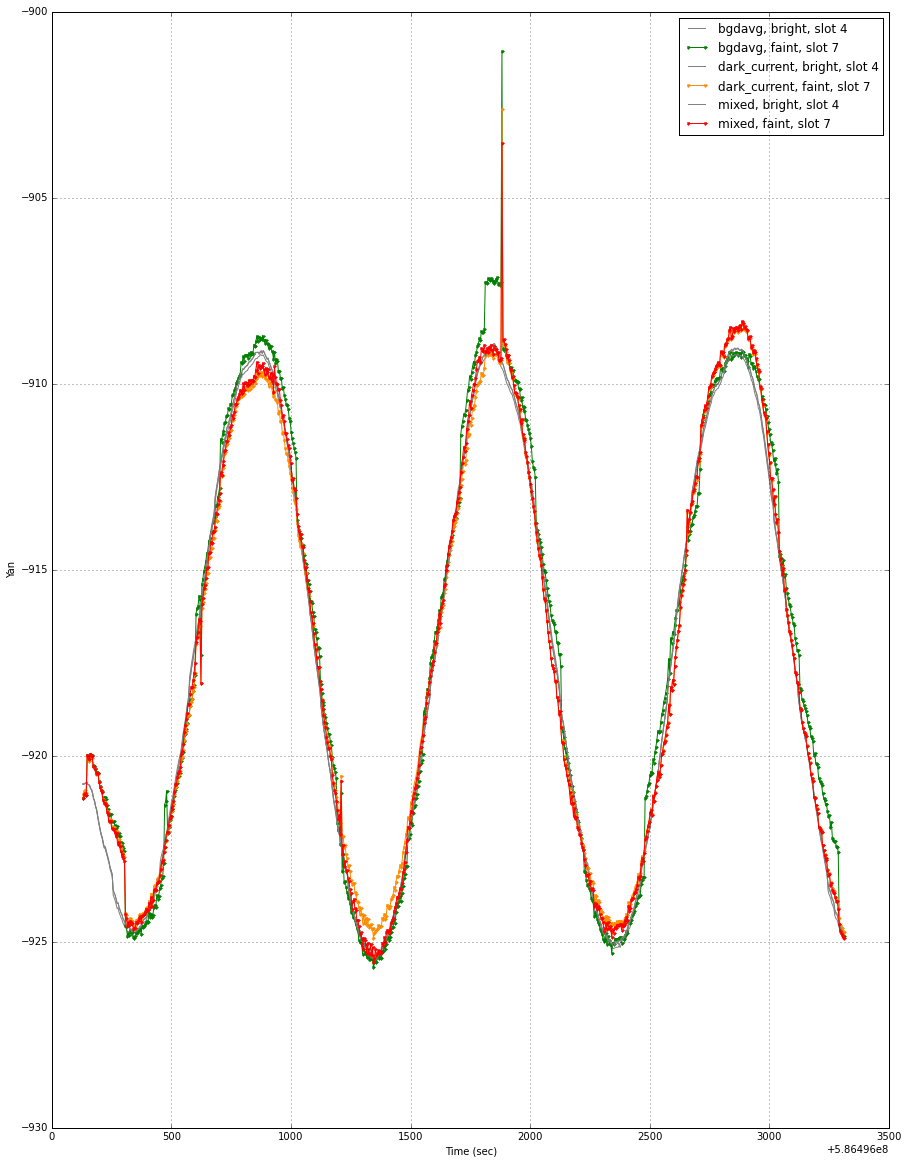

In [27]:
fig = plt.figure(figsize=(15, 20))
color = ['green', 'darkorange', 'red']
method = ['bgdavg', 'dark_current', 'mixed']
for i, t in enumerate([t_ba, t_dc, t_m]):
    plt.plot(t['time'][2], t['yan_raw'][2][0] - 2276, color='gray',
             label=method[i] +', bright star')
    plt.plot(t['time'][7], t['yan_raw'][7][0], color=color[i], marker='.',
             label=method[i] +', faint star')
plt.ylabel("Yan")
plt.xlabel("Time (sec)")
plt.grid()
plt.legend()

In [23]:
print [(t_ba['time'][2] - t_ba['time'][slot])[:3] for slot in slots]

[array([-2.05000019, -2.04999995, -2.05000019]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([-2.05000019, -2.04999995, -2.05000019]), array([-2.05000019, -2.04999995, -2.05000019]), array([-2.05000019, -2.04999995, -2.05000019])]


Method: average background subtraction


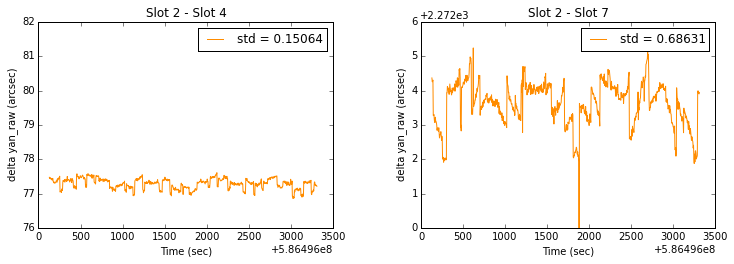

In [24]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_ba)
print "Method: average background subtraction"

Method: dark current map subtraction


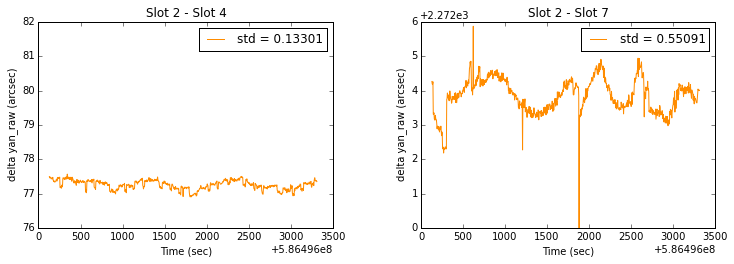

In [25]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_dc)
print "Method: dark current map subtraction"

Method: mixed map subtraction


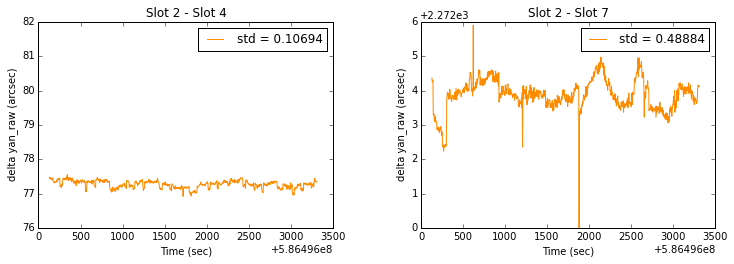

In [26]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_m)
print "Method: mixed map subtraction"

### Tests ###

__Row and Col coordinates__

In [ ]:
# Definition of (r, c) coordinates

slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
raw_image = slot_data['IMGRAW'][0]

print slot_data['TIME'][0]

print 'Raw image:'
print raw_image
print
print "Raw image (reshaped):"
print raw_image.reshape(8, 8)
print
print "Raw image (reshaped, 'F'):"
print raw_image.reshape(8, 8, order='F')
print
print "Edge pixels:"
for rr, cc in zip(r, c):
    print "(r, c) = ({}, {}): {}".format(rr, cc, raw_image.reshape(8, 8, order='F')[rr, cc])

 __edge_pixels_dict_8x8__

In [ ]:
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
frame_data = slot_data[7:8]

raw_image = frame_data['IMGRAW'][0]
row0 = frame_data['IMGROW0'][0]
col0 = frame_data['IMGCOL0'][0]

edge_pixels_dict = edge_pixels_dict_8x8(raw_image, row0, col0)

print "Raw image (reshaped):"
print raw_image.reshape(8, 8, order='F')
print
print "Row0, Col0 = {}, {}".format(row0, col0)
print
rr = row0 + shift
cc = col0 + shift
print "Row, Col in 1024x1024 = {}, {}".format(rr, cc)
print
print "edge_pixels_dict:"
print edge_pixels_dict
print
print "Verify some edge values:"
print
print "Upper left = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc)])
print "Upper right = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc + 7)])
print "Lower left = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc)])
print "Lower right = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 7)])
print "Row 2, Col 0 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 2, cc)])
print "Row 7, Col 6 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 6)])